In [1]:
from qiskit import QuantumCircuit, assemble
from qiskit.visualization import plot_histogram, plot_bloch_vector
from qiskit.quantum_info import Clifford, random_clifford
from math import sqrt, pi
import time
import torch as tc
from Library.Tools import *
import numpy as np
from Library.PhysModule import multi_mags_from_states
from Library.PhysModule import reduced_density_matrces as PhyRDM

# 函数定义

In [14]:
def get_quantum_gates_and_qubits(qc):
    gates_info = []
    for gate in qc.data:
        gate_name = gate.name  # 获取量子门的名称
        qubits = gate.qubits  # 获取作用的比特
        gates_info.append((gate_name, [qc.qubits.index(qubit) for qubit in qubits]))  # 记录量子门及其作用的比特索引
    return gates_info


In [15]:
def convert_qiskit_circuit_to_usual_gates(qiskit_circuit):
    x_gate = tc.tensor([[0, 1], [1, 0]], dtype=tc.complex64)
    y_gate = tc.tensor([[0, -1j], [1j, 0]], dtype=tc.complex64)
    z_gate = tc.tensor([[1, 0], [0, -1]], dtype=tc.complex64)
    s_gate = tc.tensor([[1, 0], [0, 1j]], dtype=tc.complex64)
    sdg_gate = tc.tensor([[1, 0], [0, -1j]], dtype=tc.complex64)
    h_gate = tc.tensor([[1/(2**0.5), 1/(2**0.5)], [1/(2**0.5), -1/(2**0.5)]], dtype=tc.complex64)

    cnot_gate = tc.tensor([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]], dtype=tc.complex64).reshape(2, 2, 2, 2)
    swap_gate = tc.tensor([[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]], dtype=tc.complex64).reshape(2, 2, 2, 2)

    gate_dict = {
        'x': x_gate,
        'y': y_gate,
        'z': z_gate,
        's': s_gate,
        'sdg': sdg_gate,
        'h': h_gate,
        'cx': cnot_gate,
        'swap': swap_gate
    }

    gates_info = get_quantum_gates_and_qubits(qiskit_circuit)
    gate_list = list(gate_dict.values())
    gate_names = list(gate_dict.keys())

    which_where = []
    for gate_name, qubit_indices in gates_info:
        # print(f"Gate: {gate_name}, Qubits: {qubit_indices}")
        which_where.append([gate_names.index(gate_name)] + qubit_indices)
    
    return gate_names, gate_list, which_where


In [16]:
def generate_unitary_2_design_states(number:int, n_qubit:int):
    state = tc.zeros((2**n_qubit), dtype=tc.complex64)
    state[0] = 1 + 0.j
    state = state.reshape([2] * n_qubit)
    state = state.unsqueeze(0)
    state_list = list()
    for i in range(number):
        cliff = random_clifford(n_qubit)
        qc = cliff.to_circuit()
        gate_names, gate_list, which_where = convert_qiskit_circuit_to_usual_gates(qc)
        rand_state = pure_states_evolution(state, gate_list, which_where)
        state_list.append(rand_state)
    u2d_states = tc.cat(state_list, dim=0)
    return u2d_states


In [17]:
def measure(state):
    shape = state.shape
    state = state.reshape(-1)
    probabilities = tc.abs(state) ** 2
    # 根据概率分布进行测量
    measured_index = tc.multinomial(probabilities, 1, replacement=True).item()  # 进行测量
    measured_state = tc.zeros_like(state)
    measured_state[measured_index] = 1  # 设置对应的量子态为1

    return measured_state.reshape(shape)


In [18]:
def measure_n_times(state, number:int):
    '''
    返回测量n次得到的平均密度矩阵
    '''
    shape = state.shape
    state = state.reshape(-1)
    probabilities = tc.abs(state) ** 2
    # 根据概率分布进行多次测量
    measured_indices = tc.multinomial(probabilities, number, replacement=True)  # 进行多次测量
    # 统计每个测量结果的出现次数
    counts = tc.bincount(measured_indices, minlength=state.shape[0])
    pd = counts / tc.sum(counts)
    avg_state = tc.sqrt(pd)
    avg_rho = tc.diag(pd)
    return avg_state.reshape(shape).to(dtype=state.dtype)

In [19]:
def sample_classical_shadow(aim_state, n_qubit, num_sample=10000):
    '''
    state的形状为[number_of_states]+[2]*n_qubit
    '''
    cliff = random_clifford(n_qubit)
    qc = cliff.to_circuit()
    gate_names, gate_list, which_where = convert_qiskit_circuit_to_usual_gates(qc)
    U_state = pure_states_evolution(aim_state, gate_list, which_where)
    # b_state = measure(U_state)
    b_state = measure_n_times(U_state, num_sample)

    inverse_qc = qc.inverse()
    gate_names, gate_list, which_where = convert_qiskit_circuit_to_usual_gates(inverse_qc)
    sigma_state = pure_states_evolution(b_state, gate_list, which_where)
    sigma = tc.einsum('a, b -> ab', sigma_state.reshape(-1), sigma_state.reshape(-1).conj())
    Eye = tc.eye(2**n_qubit, dtype=tc.complex64)
    rho_sample = (2**n_qubit + 1) * sigma - Eye
    return rho_sample


In [20]:
def matrix_sqrt(A, tol=1e-6):
    """
    计算复数矩阵 A 的平方根，使用特征值分解。
    
    参数：
    A (torch.Tensor): 复数矩阵。
    
    返回：
    torch.Tensor: 复数矩阵 A 的平方根。
    """
    # 进行特征值分解
    eigenvalues, eigenvectors = tc.linalg.eigh(A)
    
    # 对特征值进行裁剪：小于 tol 的特征值设置为零
    eigenvalues = tc.where(tc.abs(eigenvalues) < tol, tc.tensor(0.0, dtype=eigenvalues.dtype), eigenvalues)

    # 计算特征值的平方根
    eigenvalues_sqrt = tc.sqrt(eigenvalues)
    
    # 构造平方根矩阵
    A_sqrt = eigenvectors @ tc.diag(eigenvalues_sqrt).to(dtype=tc.complex64) @ eigenvectors.T.conj()
    
    return A_sqrt


In [21]:
def fidelity_density_matrices(rho, sigma):
    """
    计算两个复数密度矩阵 rho 和 sigma 之间的保真度。
    
    参数：
    rho (torch.Tensor): 复数密度矩阵 rho。
    sigma (torch.Tensor): 复数密度矩阵 sigma。
    
    返回：
    float: 两个密度矩阵之间的保真度。
    """
    # 计算 sqrt(rho)
    sqrt_rho = matrix_sqrt(rho)  # 使用自定义的 matrix_sqrt 函数计算复数矩阵的平方根
    
    # 计算 sqrt(rho) * sigma * sqrt(rho)
    product = tc.matmul(tc.matmul(sqrt_rho, sigma), sqrt_rho)
    
    # 计算 sqrt(sqrt(rho) * sigma * sqrt(rho))
    sqrt_product = matrix_sqrt(product)  # 计算 sqrt(sqrt(rho) * sigma * sqrt(rho))
    
    # 计算保真度 F = Tr(sqrt(sqrt(rho) * sigma * sqrt(rho)))
    return tc.abs(tc.trace(sqrt_product))**2


In [22]:
def reduced_density_matrix(rho:tc.Tensor, pos:list, length:int):
    '''
    求关于pos的约化密度矩阵。例如 pos=[0] 表示求关于第0个指标的约化密度矩阵，返回一个 (2, 2) 的矩阵
    '''
    # length = int(np.log2(rho.shape[0]))
    rho = rho.reshape([2] * (length*2))
    perm_0 = [_ for _ in range(length)]
    perm_1 = [_ for _ in range(length, 2*length)]
    dim_a = 1
    dim_b = 2 ** length
    pos_ = []
    for i in pos:
        pos_.append(i + length)
        perm_0.remove(i)
        perm_1.remove(i + length)
        dim_a = dim_a * 2
        dim_b = int(dim_b / 2)
    perm = pos + perm_0 + pos_ + perm_1
    rho_tmp = rho.permute(perm)
    rho_tmp = rho_tmp.reshape([dim_a, dim_b, dim_a, dim_b])
    reduced_rho = tc.einsum('ibjb->ij', rho_tmp)
    return reduced_rho


In [23]:
def multi_mags_from_rho(rho, length):
    # length = int(np.log2(rho.shape[0]))
    rho = rho.reshape([2] * length *2)
    sigma_x = tc.tensor([[0, 1], [1, 0]], dtype=rho.dtype)
    sigma_y = tc.tensor([[0, -1j], [1j, 0]], dtype=rho.dtype)
    sigma_z = tc.tensor([[1, 0], [0, -1]], dtype=rho.dtype)
    which_ops = [sigma_x*0.5, sigma_y*0.5, sigma_z*0.5]
    mags = tc.zeros((3, length), device=rho.device)
    for i in range(length):
        reduced_rho = reduced_density_matrix(rho, pos=[i], length=length)
        for s in range(3):
            # print(rho)
            # print(which_ops[s])
            obs = which_ops[s]
            mags[s, i] = tc.einsum('bc,cb->', reduced_rho.type(tc.complex64), obs.type(tc.complex64)).real
    return mags


In [24]:
def cal_mean_mag_on_site_index(count_state, i):
    '''
    count_state.shape is [2] * n_qubit
    '''
    n_qubit = count_state.ndim
    perm = [_ for _ in range(n_qubit)]
    perm[0] = i
    perm[i] = 0
    count_state = count_state.permute(perm)
    count_state = count_state.reshape([2, -1])
    mag_i_count = tc.sum(count_state, dim=1)
    mean_mag_i = (0.5 * mag_i_count[0] + -0.5 * mag_i_count[1]) / (mag_i_count[0] + mag_i_count[1])
    return mean_mag_i.real

# 测试shadow tomography

In [25]:
def fidelity_from_classical_shadow(state, num_sample, num_basis):
    '''
    state的形状为[number_of_states] + [2]*n_qubit
    '''
    avg_rho = 0
    number = num_basis * 11
    mean_fidelity_list = []
    # rho = tc.einsum('a, b -> ab', state.reshape(-1), state.reshape(-1).conj())
    for i in range(number):
        rho_sample = sample_classical_shadow(state, n_qubit, num_sample)
        avg_rho = avg_rho + rho_sample
        if i % num_basis == num_basis-1:
            avg_rho = avg_rho / num_basis
            fidelity = tc.einsum('a, ab, b ->', state.reshape(-1).conj(), avg_rho, state.reshape(-1)).real
            mean_fidelity_list.append(fidelity)
            avg_rho = 0
    return mean_fidelity_list

n_qubit = 5
# state = tc.rand((2**n_qubit), dtype=tc.complex64)
state = tc.rand(2, dtype=tc.complex64)
for i in range(n_qubit-1):
    state = tc.einsum('a, b -> ab', state, tc.rand(2, dtype=tc.complex64))
    state = state.reshape(-1)
state = state / tc.norm(state)
state = state.reshape([2] * n_qubit)
state = state.unsqueeze(0)
print(state.shape)

basis_list = [i*300 for i in range(1, 11)]
fidelity = []
time_list = []
for num_basis in basis_list:
    print('num_basis = ', num_basis)
    t1 = time.time()
    mean_fidelity_list = fidelity_from_classical_shadow(state, 100000, num_basis=num_basis)
    fidelity.append(mean_fidelity_list)
    t2 = time.time()
    print(t2 - t1)
    print()
    time_list.append(t2-t1)
# multi_mags_sample = tc.stack(multi_mags_list, dim=0)
# print(multi_mags_sample.shape)
# median_multi_mags, _ = tc.median(multi_mags_sample, dim=0)
# print(median_multi_mags - multi_mags_real)

torch.Size([1, 2, 2, 2, 2, 2])
num_basis =  300
44.67446517944336

num_basis =  600
70.6716468334198

num_basis =  900
118.5466194152832

num_basis =  1200
163.23066592216492

num_basis =  1500


KeyboardInterrupt: 

- 实验结果

torch.Size([1, 2, 2, 2, 2, 2])

num_basis =  3
0.23209691047668457

num_basis =  30
1.9153223037719727

num_basis =  60
3.759786605834961

num_basis =  90
6.546694755554199

num_basis =  120
8.045798540115356

num_basis =  150
9.348260164260864

num_basis =  180
10.286007642745972

num_basis =  210
15.281891584396362

num_basis =  240
25.384276151657104

num_basis =  270
25.581177473068237

num_basis =  300
35.129565954208374

num_basis =  3000
378.68991017341614

num_basis =  6000
993.3943264484406

num_basis =  9000
911.1991903781891

- 实验结果2

torch.Size([1, 2, 2, 2, 2, 2])

num_basis =  300
16.430874586105347

num_basis =  600
31.312135696411133

num_basis =  900
48.63883566856384

num_basis =  1200
63.95498204231262

num_basis =  1500
82.71075224876404

num_basis =  1800
90.55077004432678

num_basis =  2100
114.74883365631104

num_basis =  2400
134.79453921318054

num_basis =  2700
158.37383460998535

num_basis =  3000
169.26471877098083



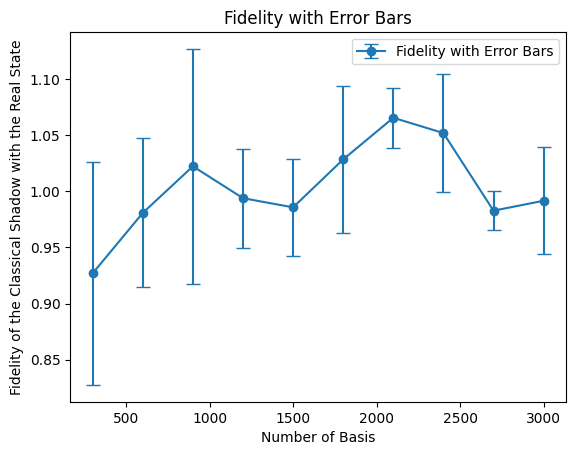

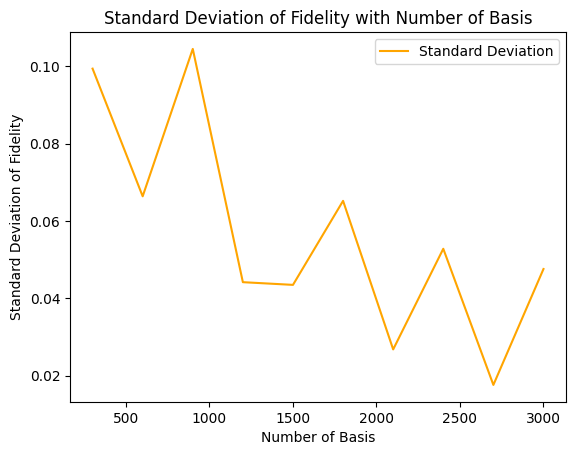

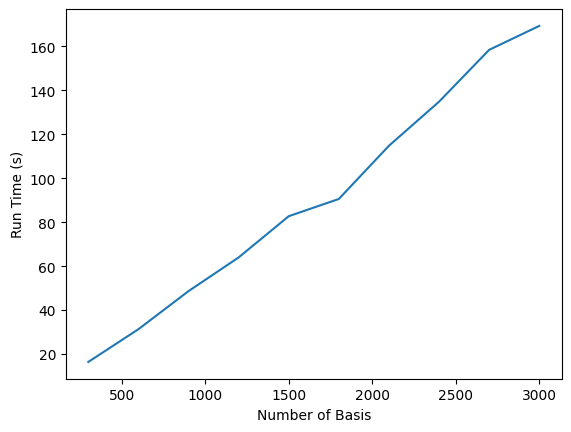

In [18]:
from textwrap import wrap
import matplotlib.pyplot as plt

result = np.array(fidelity)
median, std = np.median(fidelity, axis=1), result.std(axis=1)

plt.errorbar(basis_list, median, yerr=std, fmt='-o', capsize=5, label='Fidelity with Error Bars')
plt.xlabel('Number of Basis')
plt.ylabel('Fidelity of the Classical Shadow with the Real State', wrap=True)
plt.title('Fidelity with Error Bars')
plt.legend()
plt.show()

plt.close()  # Close the previous plot
plt.plot(basis_list, std, label='Standard Deviation', color='orange')
plt.xlabel('Number of Basis')
plt.ylabel('Standard Deviation of Fidelity')
plt.title('Standard Deviation of Fidelity with Number of Basis')
plt.legend()
plt.show()

plt.close()
plt.plot(basis_list, time_list)
plt.xlabel('Number of Basis')
plt.ylabel('Run Time (s)')
plt.show()

通过shadow tomography得到态保真度所需的时间随基底数量的增加呈大致线性关系

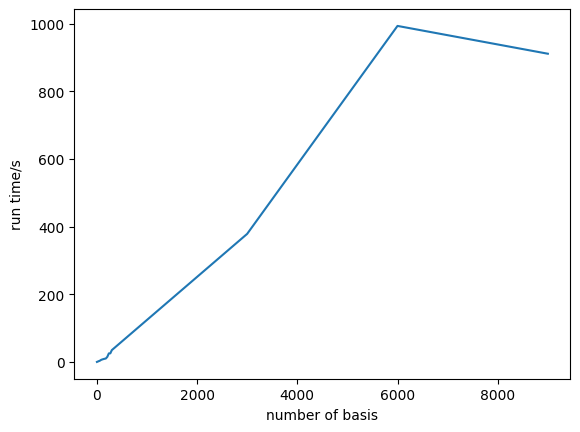

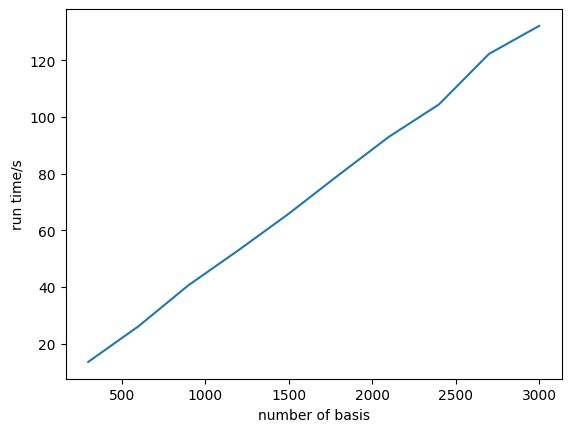

准确度随着基底数量的增加而增加，在基底数量为300时标准差大概为0.1，在基底数量为3000时大概为0.02

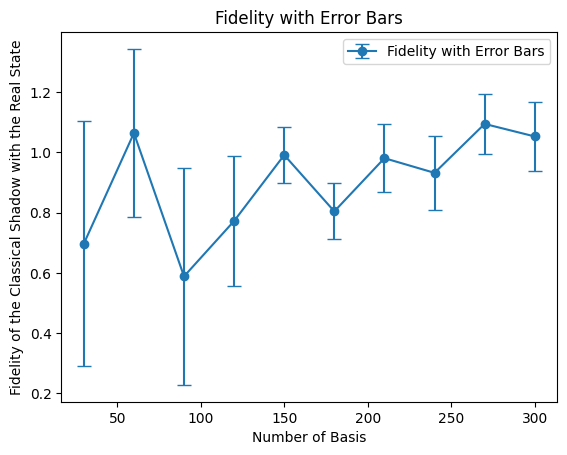
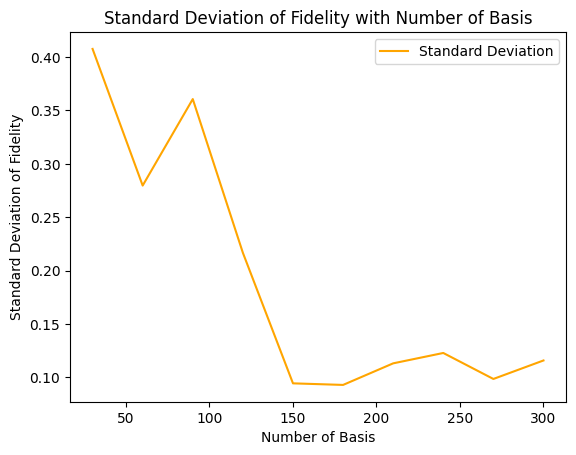

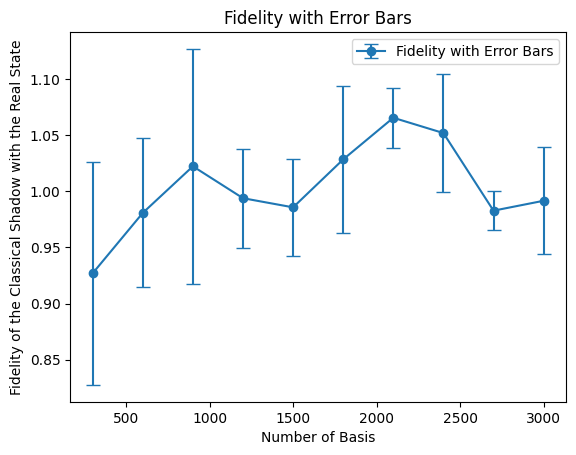
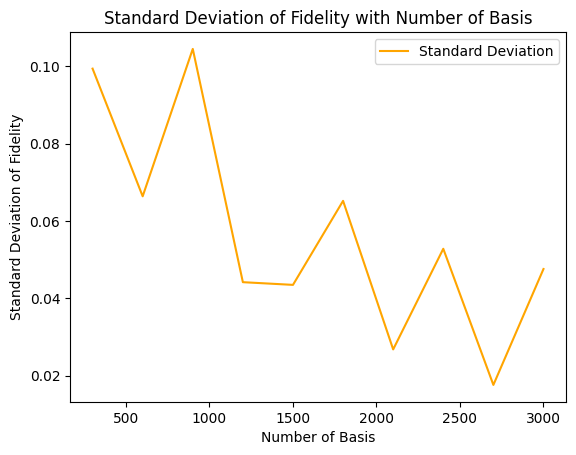

# 测试通过测量得到局域磁矩

In [15]:
n_qubit = 5
state = tc.rand(2, dtype=tc.complex64)
for i in range(n_qubit-1):
    state = tc.einsum('a, b -> ab', state, tc.rand(2, dtype=tc.complex64))
    state = state.reshape(-1)
state = state / tc.norm(state)
state = state.reshape([2] * n_qubit)
# state = state.unsqueeze(0)
print(state.shape)

rho = tc.einsum('a, b -> ab', state.reshape(-1), state.reshape(-1).conj())

# reduced_rho = reduced_density_matrix(rho, pos=[0])
# print(reduced_rho)

# reduced_rho_ = PhyRDM(state.unsqueeze(0), pos=[0])
# print(reduced_rho - reduced_rho_[0])

multi_mags_from_rho_ = multi_mags_from_rho(rho, length=n_qubit)
# multi_mags_from_states_ = multi_mags_from_states(states=state.unsqueeze(0))
# print(multi_mags_from_rho_)
# print(multi_mags_from_states_[0])

count_state = tc.zeros_like(state)
for i in range(1024*10):
    measured_state = measure(state)
    count_state = count_state + measured_state

mean_mags = [cal_mean_mag_on_site_index(count_state=count_state, i=k) for k in range(n_qubit)]

print('-'*10 + 'mag_z from sample' + '-'*10)
print(mean_mags)
print('-'*10 + 'mag_z from calculate' + '-'*10)
print(multi_mags_from_rho_[2,:])
print('-'*10 + 'difference' + '-'*10)
print(tc.tensor(mean_mags) - multi_mags_from_rho_[2,:])


torch.Size([2, 2, 2, 2, 2])
----------mag_z from sample----------
[tensor(-0.1131), tensor(-0.0998), tensor(0.4479), tensor(0.2587), tensor(0.1987)]
----------mag_z from calculate----------
tensor([-0.1204, -0.1047,  0.4444,  0.2532,  0.1937])
----------difference----------
tensor([0.0074, 0.0049, 0.0034, 0.0055, 0.0051])


# 测试PhysModule.py中的sample_classical_shadow()

In [12]:
from Library.PhysModule import sample_classical_shadow

n_qubit = 2

state_num = 3
shape = [state_num]+[2]*n_qubit
states = tc.rand(size=shape, dtype=tc.complex64)
states = states.reshape(shape=[state_num, -1])
print(states.shape)
states = states / tc.sqrt(tc.einsum('na, na -> n', states, states.conj()).real).unsqueeze(1)
print(states.shape)
states = states.reshape(shape)

num_sample = 100

shadow = sample_classical_shadow(aim_states=states, n_qubit=n_qubit, num_sample=num_sample)

print(tc.einsum('naa->n',shadow))

print(shadow.shape)
print(tc.norm(tc.einsum('nab->nba', shadow).conj() - shadow))

torch.Size([3, 4])
torch.Size([3, 4])
tensor([1.0000+4.4409e-16j, 1.0000-1.7764e-15j, 1.0000+0.0000e+00j])
torch.Size([3, 4, 4])
tensor(2.4553e-07)


# 测试WorkFlow.TrainModel中的loss_sample_fide

In [12]:
from WorkFlow.TrainModel import loss_sample_fide

n_qubit = 2

state_num = 5
def rand_states(n_qubit, state_num):
    shape = [state_num]+[2]*n_qubit
    states = tc.rand(size=shape, dtype=tc.complex64)
    states = states.reshape(shape=[state_num, -1])
    print(states.shape)
    states = states / tc.sqrt(tc.einsum('na, na -> n', states, states.conj()).real).unsqueeze(1)
    print(states.shape)
    states = states.reshape(shape)
    return states

real = rand_states(n_qubit, state_num)
pred = rand_states(n_qubit, state_num)

_ = tc.einsum('na, na->n',real.reshape([state_num, -1]), pred.reshape([state_num, -1]).conj())
print(tc.einsum('n, n->n', _, _.conj()).real)

avg_fidelity = loss_sample_fide(real, pred)
print(avg_fidelity)
loss = tc.norm(tc.ones_like(avg_fidelity) - avg_fidelity)/state_num
print(loss)

torch.Size([5, 4])


torch.Size([5, 4])
torch.Size([5, 4])
torch.Size([5, 4])
tensor([0.8412, 0.6903, 0.6888, 0.6156, 0.6252])
tensor([0.8357, 0.6993, 0.7017, 0.6151, 0.6272])
tensor(0.1405)


In [13]:
print(tc.norm(tc.ones_like(avg_fidelity) - avg_fidelity))

tensor(0.7025)


In [14]:
test_fide = loss_sample_fide(real, real)
print(tc.norm(tc.ones_like(test_fide) - test_fide))

tensor(0.0596)


In [15]:
print(test_fide)

tensor([0.9832, 0.9921, 0.9517, 1.0264, 0.9868])
